In [36]:
import random
import sortedcontainers
import numpy as np
from scipy.spatial import distance
from numpy.linalg import norm as vector_norm
import matplotlib.pyplot as plt

def neg_dot_prod(v1,v2):
    return -np.dot(v1,v2)

def eucl_dist(v1, v2):
    return distance.euclidean(v1, v2)

In [148]:
class Node:
    ''' Graph node class. Major properties are `value` to access embedding and `neighbourhood` for adjacent nodes '''
    def __init__(self, value, idx):
        self.value = value
        self.idx = idx
        self.neighbourhood = set()
        
class NSWGraph:
    
    def __init__(self, values=None, dist=None):
        self.dist = dist if dist else lambda a, b: eucl_dist(a[0], b[0])
        self.nodes = [Node(node, i) for i, node in enumerate(values)] if values else []
        
    def get_edges(self):
        for i, node in enumerate(self.nodes):
            for n in node.neighbourhood:
                yield (i, n)
        
    def search_nsw_basic(self, query, top=5, guard_hops=100):
        ''' basic algorithm, takes vector query and returns a pair (nearest_neighbours, hops)'''
        candidates = sortedcontainers.SortedList()
        result = sortedcontainers.SortedList()
        visitedSet = set()

        # taking random node as an entry point
        current = random.randint(0, len(self.nodes) - 1)
        candidates.add((self.dist(query, self.nodes[current].value), current))
        result.add((self.dist(query, self.nodes[current].value), current))

        hops = 0
        while hops < guard_hops:
            hops += 1
            if len(candidates) == 0: break
            closest_sim, с = candidates.pop()        
            # k-th best
            if len(result) >= top:
                if result[top-1][0] < closest_sim: break

            for friend in self.nodes[с].neighbourhood:
                if friend not in visitedSet:
                    visitedSet.add(friend)
                    sim = self.dist(query, self.nodes[friend].value)
                    candidates.add((sim, friend))
                    result.add((sim, friend))

        return [v for k, v in result[:top]], hops
    
    def multi_search(self, query, attempts=1, top_k=5):   
        '''Implementation of `K-NNSearch`, but without keeping the visitedSet'''
        result = set()
        for i in range(attempts):
            closest, hops = self.search_nsw_basic(query, top=top_k)
            result.update(closest)    
        index = list((i, self.dist(query, self.nodes[i].value)) for i in result)    
        sorted_index = sorted(index, key=lambda pair: pair[1])[:top_k]
        return [x[0] for x in sorted_index]
    
    def build_navigable_graph(self, values, K=5, multi_n=3):
        '''Accepts container with values. Returns list with graph nodes'''
        # create graph with one node
        self.nodes.append(Node(values[0], len(self.nodes)))
        # insert the remaining nodes one at a time
        for i in range(1, len(values)):
            val = values[i]
            # search K nearest neighbors of the current value existing in the graph
            top_k = min(len(self.nodes), K) # for the first K insertions            
            closest = self.multi_search(val, multi_n, top_k)
            # create a new node
            self.nodes.append(Node(val, len(self.nodes) + 1))
            # connect the closest nodes to the current node
            self.nodes[len(self.nodes) - 1].neighbourhood.update(closest)
            # connect the current node to the closest values
            for c in closest:
                self.nodes[c].neighbourhood.add(len(self.nodes) - 1)
    
    def plot(self):
        plt.figure(figsize=(10, 10))     
        middles = []
        for e in self.get_edges():
            n0, n1 = self.nodes[e[0]], self.nodes[e[1]]
            sx, sy = n0.value[0]
            fx, fy = n1.value[0]
            # plot only relatively short edges
            if self.dist(n0.value, n1.value) > 0.2:
                continue

            if n0.value[1] != n1.value[1]:
                plt.plot([sx, fx], [sy, fy], linewidth=1, c='#FFAA00')
                middles.append((n0.value[0] + n1.value[0]) / 2.)
            else:
                plt.plot([sx, fx], [sy, fy], linewidth=1, c='#DDDDDD')

        markers = ['o', '>']
        for i, m in enumerate(markers):
            x = [node.value[0][0] for node in self.nodes if node.value[1] == i]
            y = [node.value[0][1] for node in self.nodes if node.value[1] == i]
            plt.scatter(x, y, marker=m, s=20)
            
        plt.scatter([v[0] for v in middles], [v[1] for v in middles], marker='*', s=100)
        
        plt.show()

In [149]:
G = NSWGraph()

N = 400
values = []
for i in range(N):
    p = np.array([random.random(), random.random()])
    cls = 1 if vector_norm(p) > 0.8 else 0
    values.append((p, cls))

        
G.build_navigable_graph(values, K=7, multi_n=3)

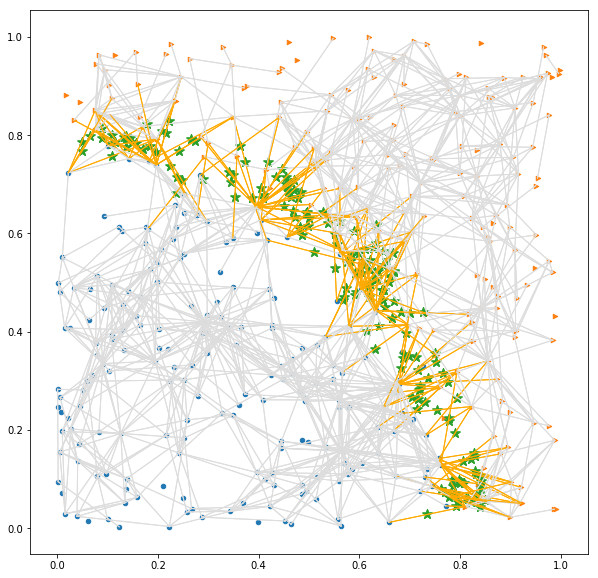

In [150]:
G.plot()

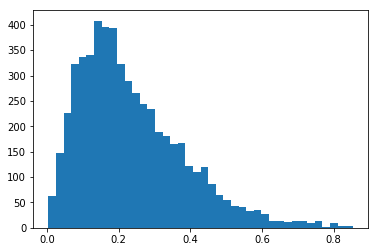

In [157]:
edges = [G.dist(G.nodes[e[0]].value, G.nodes[e[1]].value) for e in G.get_edges()]

plt.hist(edges, bins=40)
plt.show()

In [171]:
# https://stackoverflow.com/questions/36795949/python-testing-if-my-data-follows-a-lognormal-distribution
from  scipy.stats import lognorm, poisson, kstest
shape, loc, scale = lognorm.fit(edges)
print("Params", shape, loc, scale)
print("Params log(scale), shape =", np.log(scale), shape)
expected_value = shape * scale
print("E =", expected_value) # edge length

Params 0.4772533089097223 -0.06931196915991852 0.2742170016638802
Params log(scale), shape = -1.2938355091667924 0.4772533089097223
E = 0.13087097140338963


In [159]:
# https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.stats.kstest.html
kstest(edges, "lognorm", lognorm.fit(edges))
# both numbers are rather small. Highly likely to have lognorm

KstestResult(statistic=0.02070298548443561, pvalue=0.017349739378458892)

In [178]:
from scipy.optimize import curve_fit
from scipy.special import factorial
import math

def psn(x, k, l, loc, scale):
    return (l ** k) * (math.e ** (-l)) / factorial(k)

entries, bin_edges, patches = plt.hist(edges, bins=20)

def _poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)
# calculate binmiddles
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

curve_fit(_poisson, bin_middles, edges)


# parameters, cov_matrix = curve_fit(poisson, bin_middles, entries)

ValueError: operands could not be broadcast together with shapes (20,) (5538,) 